<h2>06 IBM Capstone Space X Dash & Plotly</h2>

In this jupyter notebook it can be found data of Space X launching information, regarding launching sites and success of missions. Making an interactive Dash application for reviewing the data.
In this notebook we will see the step-by-step formation of the interactive app.

<h3>Importing yard:</h>


In [27]:
# Import required libraries, if not installed it just requires pip install
import pandas as pd
import plotly.express as px
import wget
import dash
from dash import html
from dash import  dcc
from dash.dependencies import Input, Output

<h4> Data wrangling section: </h4>

The data will be loaded from the Coursera cloud prepared for this certification.

In [28]:
# Download and read the `spacex_launch_geo.csv`
spacex_csv_file = wget.download('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv')
spacex_df=pd.read_csv(spacex_csv_file)
spacex_df.head()

#Validate that the payload limits are useful for the Dash app 
max_payload = spacex_df['Payload Mass (kg)'].max()
min_payload = spacex_df['Payload Mass (kg)'].min()

print('The minimum payload mass is: ', min_payload)
print('The maximum payload mass is: ', max_payload)

The minimum payload mass is:  0.0
The maximum payload mass is:  9600.0


We will continue gathering the important information that we require for the visualization.

In [29]:
spacex_resume = spacex_df[['Launch Site', 'class']].loc[spacex_df['class']==1].groupby('Launch Site').value_counts()

spacex_resume.head()

Launch Site   class
CCAFS LC-40   1         7
CCAFS SLC-40  1         3
KSC LC-39A    1        10
VAFB SLC-4E   1         4
dtype: int64

Preparing and debugging the pie chart for the Dash app

In [30]:
#Testing the visualization of the pie chart using all of the launching sites
fig1 = px.pie(data_frame = spacex_df, names='Launch Site', values='class' ,title='Total Launches for All Sites')
fig1.show()

#Using 1 of the launching sites as an example to visualize the pie chart, we will use the CCAFS 
#launching site to validate that the data can be modified
CCAFS = spacex_df.loc[spacex_df['Launch Site'] == 'CCAFS LC-40']

fig2 = px.pie(data_frame = CCAFS, names='class',title='Success rate for CCAFS LC-40')
fig2.show()

The second part of the graphing validation is reviewing the Scatter plots and the manipulation that it can be done with it.

In [31]:
#We will make the scatter plot dependent 
#of the minimum and maximum payload mass that can be found on the data
filtered_data1 = spacex_df[(spacex_df['Payload Mass (kg)']>=min_payload)
      &(spacex_df['Payload Mass (kg)']<=max_payload)]

specific_df=spacex_df.loc[spacex_df['Launch Site'] == 'CCAFS LC-40']
filtered_data2 = specific_df[(specific_df['Payload Mass (kg)']>=min_payload)
      &(spacex_df['Payload Mass (kg)']<=max_payload)]

#We will use one scatter plot for showing all the data from max to min payload
#And the second scatter plot will be used with the CCAFS launching site
scatterplot1 = px.scatter(filtered_data1, x="Payload Mass (kg)", y="class", 
        color="Booster Version")
scatterplot2 = px.scatter(filtered_data2, x="Payload Mass (kg)", y="class", 
        color="Booster Version")

scatterplot1.show()
scatterplot2.show()

C:\Users\Marco\AppData\Local\Temp\ipykernel_32864\2289936200.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Creating and running a Dash application to visualize the Space X data imported:

In [34]:
# Create a dash application
app = dash.Dash(__name__)

app.layout = html.Div([

    html.H1('Space X Launch site selection:', style={'font':'bold', 'font-family':'calibri', 'text-align': 'center'}),

    dcc.Dropdown(id='site_name',
                 options=[{'label': 'All Sites', 'value': 'ALL'},
                          {'label': 'CCAFS LC-40', 'value': 'CCAFS LC-40'},
                          {'label': 'CCAFS SLC-40', 'value': 'CCAFS SLC-40'},
                          {'label': 'KSC LC-39A', 'value': 'KSC LC-39A'},
                          {'label': 'VAFB SLC-4E', 'value': 'VAFB SLC-4E'}],
                          value='ALL',
                          style={'width': '40%'}),

    html.Br(),
    html.Div(id='option-chosen', children=[]),
    dcc.Graph(id='pie-chart', figure={}),

    html.H3('Payload mass range selection:', style={'font':'bold', 'font-family':'calibri', 'text-align': 'center'}),
    html.Br(),
    dcc.RangeSlider(id='payload_slider',
                    min=0,max=10000,step=1000,
                    value=[min_payload,max_payload],
                    marks={0: '0', 2500:'2500',5000:'5000',
                    7500:'7500', 10000: '10000'}),
    html.Br(),
    html.Div(dcc.Graph(id='scatter-chart'))

])

# Connect the Plotly graphs with Dash Components to show the success rate of each launching site
@app.callback(
    [Output(component_id='option-chosen', component_property='children'),
     Output(component_id='pie-chart', component_property='figure')],
    [Input(component_id='site_name', component_property='value')]
)

def update_graph(site_name):

  option = "The launching site chosen is: {}".format(site_name)

  if site_name == 'ALL':
      fig = px.pie(data_frame = spacex_df, names='Launch Site', values='class' ,title='Total Launches for All Sites')
      return option, fig
  else:
      specific_df=spacex_df.loc[spacex_df['Launch Site'] == site_name]
      fig = px.pie(data_frame = specific_df, names='class',title='Total Launch for a Specific Site')
      return option, fig

#add callback decorator for the range slider
@app.callback(
    Output(component_id='scatter-chart', component_property='figure'),
    [Input(component_id='site_name', component_property='value'),
     Input(component_id='payload_slider', component_property='value')])

def scatter_graph(site_name, payload_slider):
  print(payload_slider)
  print(site_name)

  if site_name == 'ALL':
      filtered_data1 = spacex_df[(spacex_df['Payload Mass (kg)']>=payload_slider[0])
      &(spacex_df['Payload Mass (kg)']<=payload_slider[1])]

      scatterplot1 = px.scatter(filtered_data1, x="Payload Mass (kg)", y="class", 
        color="Booster Version")

      return scatterplot1
  else:
      
      specific_df=spacex_df.loc[spacex_df['Launch Site'] == site_name]
      filtered_data2 = specific_df[(specific_df['Payload Mass (kg)']>=payload_slider[0])
      &(spacex_df['Payload Mass (kg)']<=payload_slider[1])]

      scatterplot2 = px.scatter(filtered_data2, x="Payload Mass (kg)", y="class", 
        color="Booster Version")
      return scatterplot2

# Run the app
if __name__ == '__main__':
    app.run_server(debug=False)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__'
 * Debug mode: off
[0, 9600]
ALL
[0, 9600]
CCAFS LC-40


C:\Users\Marco\AppData\Local\Temp\ipykernel_32864\3629959235.py:73: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



[2500, 10000]
CCAFS LC-40


C:\Users\Marco\AppData\Local\Temp\ipykernel_32864\3629959235.py:73: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



[2500, 7500]
CCAFS LC-40


C:\Users\Marco\AppData\Local\Temp\ipykernel_32864\3629959235.py:73: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



<H2>Final result of the Dash app</H2>

After all of the validation and coding of the Dash environment, you can find that the app launched on the local server shows the correct manipulation and interaction of the user with the data.
Here you can find the complete data using all the launch sites and the max and min payload mass.

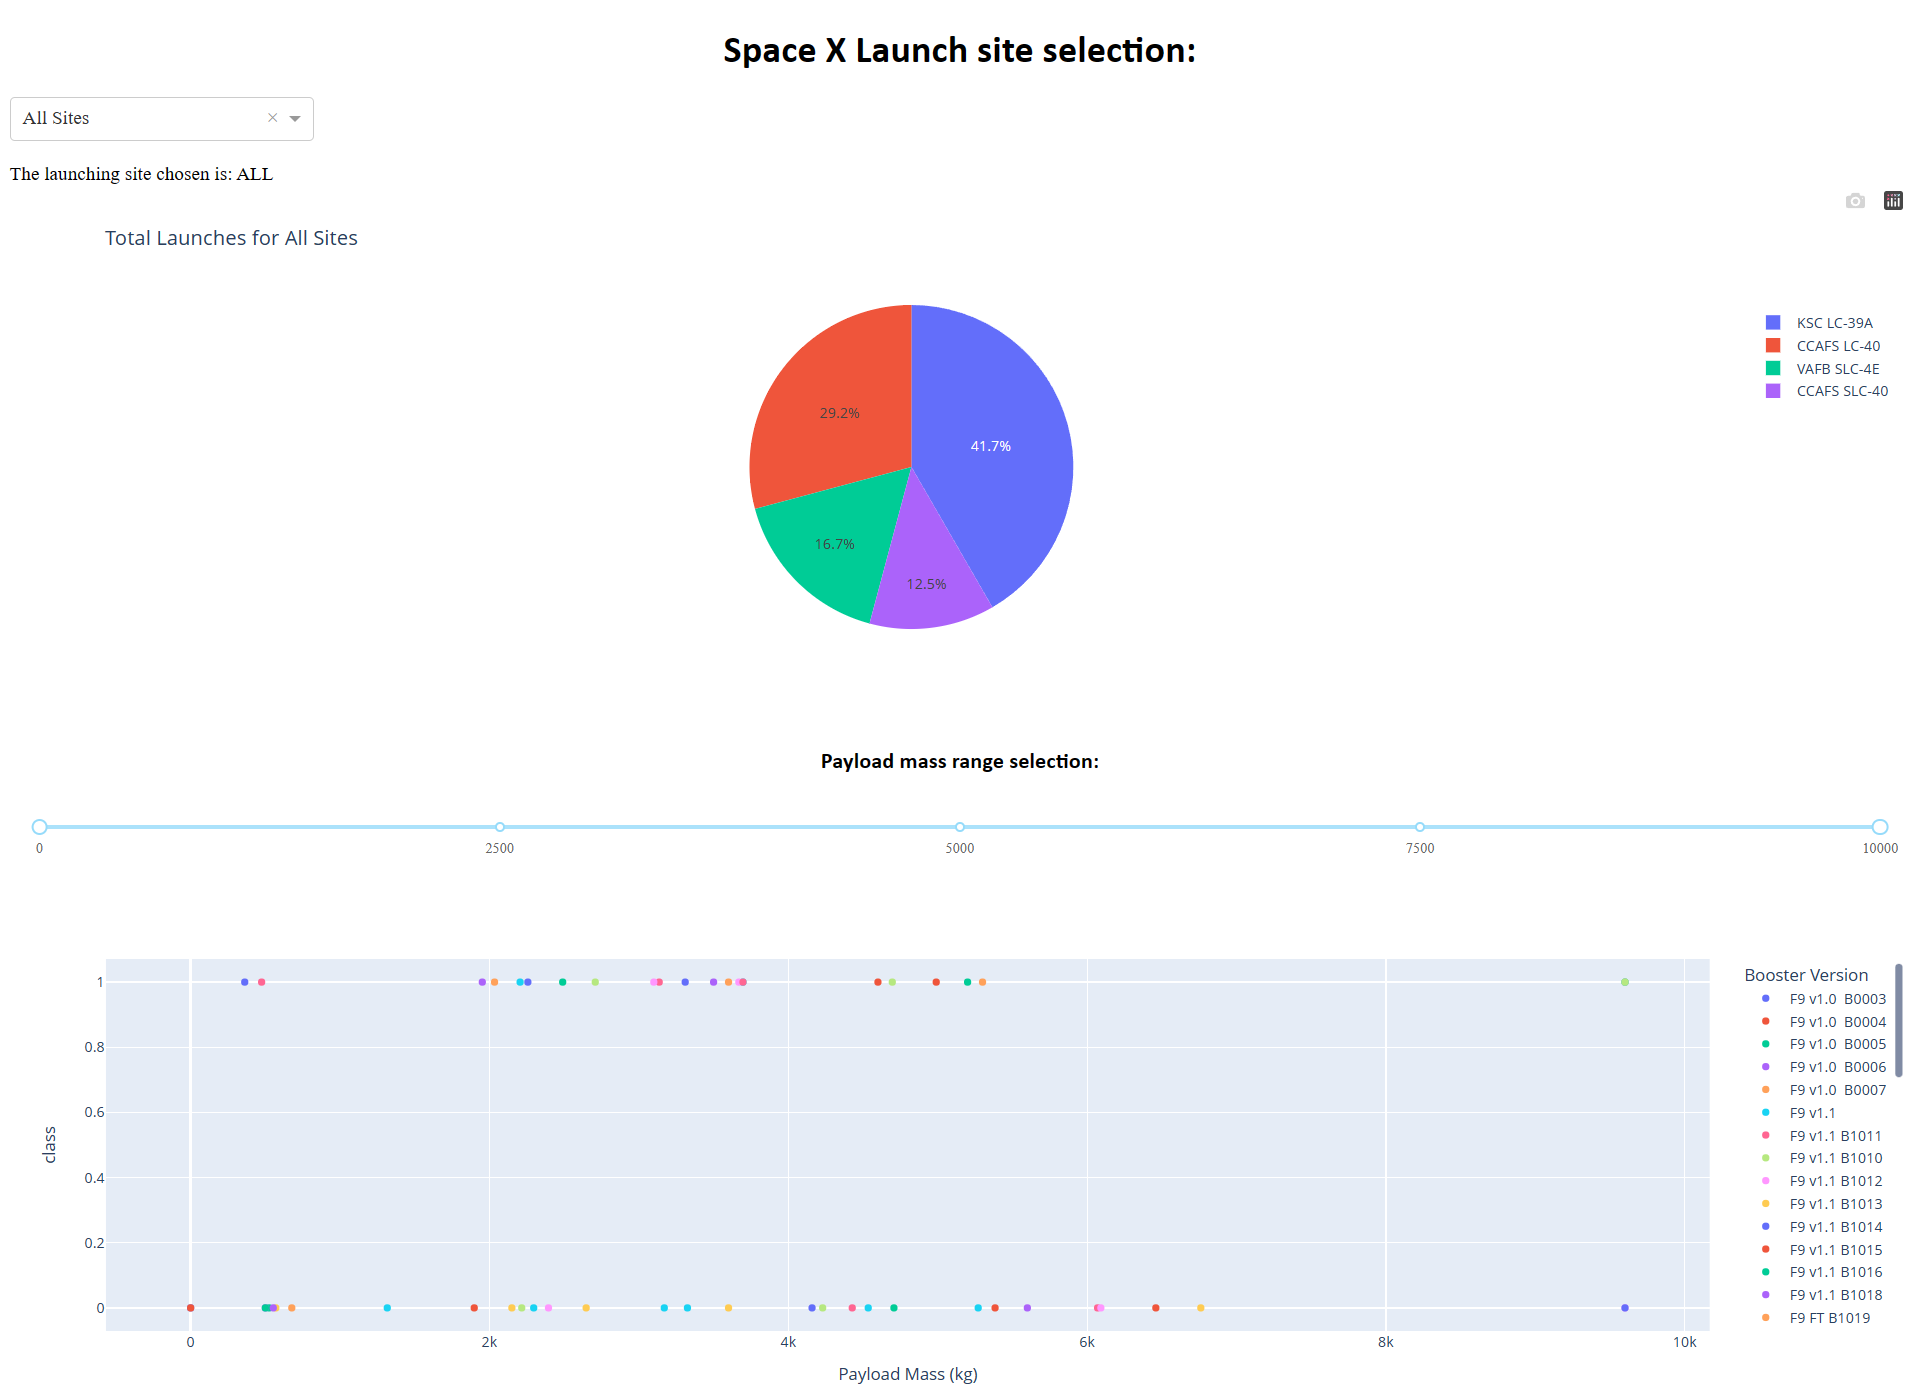

The Dash app gives the interactivility for chosing the launching site desired and the payload mass limits.

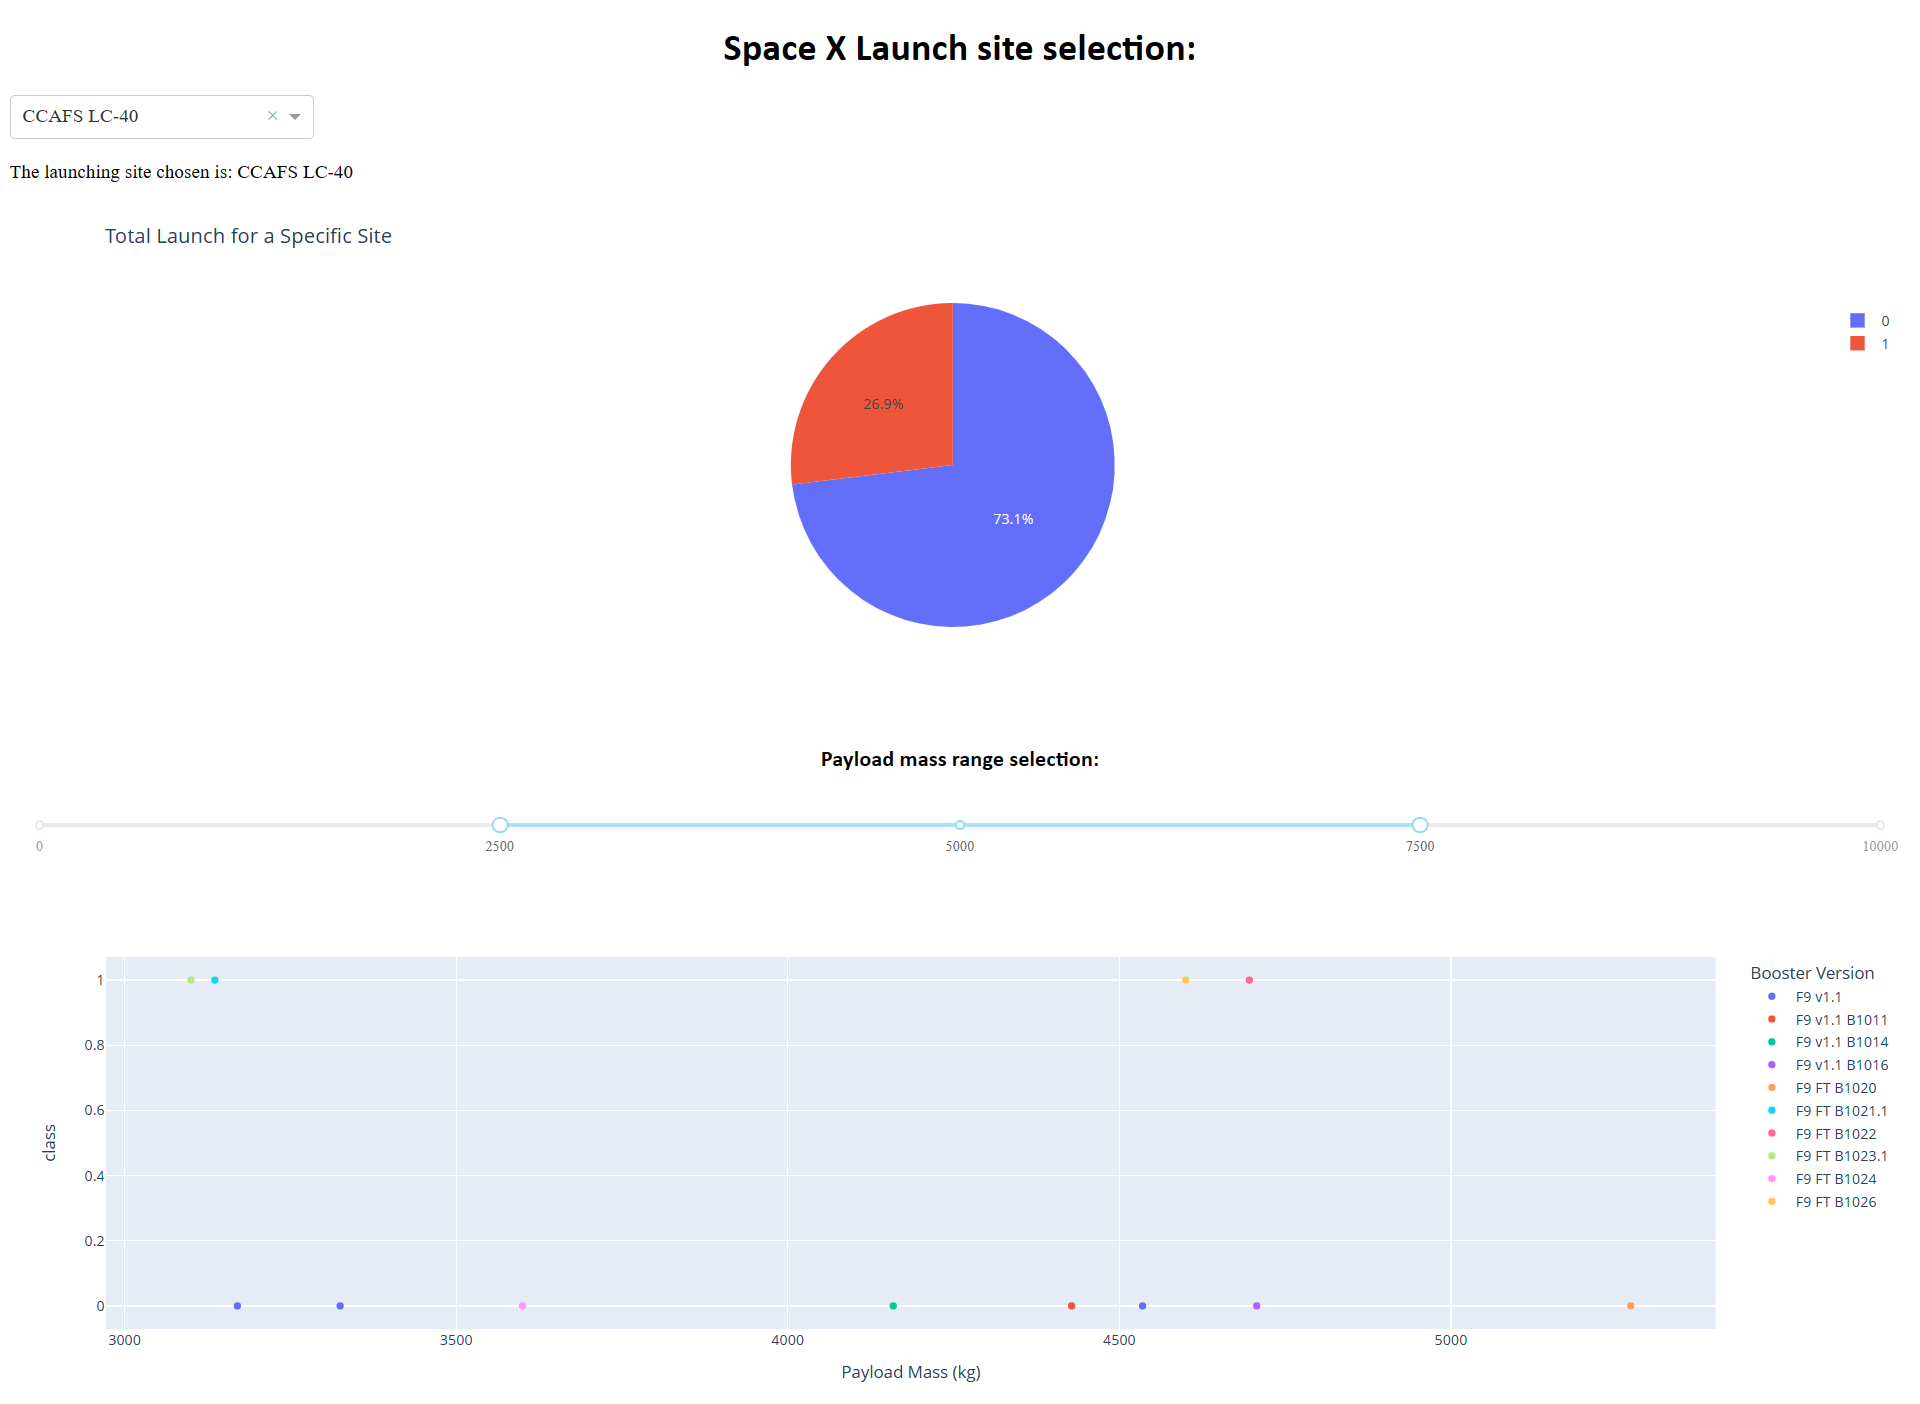